# Capstone 1 Project: Machine Learning

The goal is to predict production of different crops at county level. The data set is combined data otbained from USDA, BLS and NOAA. 

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

fileDir = os.path.dirname(os.path.abspath(''))

Reading required data.

In [2]:
data_file_path = os.path.join(fileDir, 'Data\Crop_Pivoted.xlsx')
data_df = pd.read_excel(data_file_path)

#removing all spaces in the column names, since some encoders don't really work well with spaces.
data_df=data_df.rename(columns={'ACRES PLANTED':'ACRES_PLANTED','ACRES HARVESTED':'ACRES_HARVESTED','Yearly Unemployment Rate':'Yearly_Unemployment_Rate'})

data_df.head()

,CROP,Year,State,County,ACRES_PLANTED,ACRES_HARVESTED,PRODUCTION,YIELD,PRICE,Yearly_Unemployment_Rate,avg_temp,max_temp,min_temp,percipitation
0,BARLEY,1984,ARIZONA,COCHISE,2100,2100,8467200,4032.000000,0.062500,5.175000,44.1,57.2,30.8,1.53
1,BARLEY,1985,ARIZONA,COCHISE,900,900,4200000,4666.666667,0.058750,6.333333,42.2,53.2,31.3,1.95
2,BARLEY,1986,ARIZONA,COCHISE,500,500,2016000,4032.000000,0.051458,6.925000,48.1,65.0,31.2,0.15
3,BARLEY,1987,ARIZONA,COCHISE,500,500,2304000,4608.000000,0.045625,6.450000,43.0,58.4,27.5,0.54
4,BARLEY,1989,ARIZONA,COCHISE,500,400,2116800,5292.000000,0.064583,5.358333,42.8,56.8,28.9,1.32


Making few adjustment to data, dropping not required columns, adding previous year values and combining columns.

In [3]:
# Since Yield is a calculated filed from production (yield=production/acres harvested). 
# Predicting production is the key here. Hence we will ignore yield for now.
# And Acers harvested gives a direct hint of production. Dropping 
crop_df = data_df.drop(columns=['YIELD','ACRES_HARVESTED'])

# Since a county name can be repeated between states for a given year. 
# Combing Sate and County columns.
crop_df.loc[:,'State-County']=crop_df.loc[:,'State']+' '+crop_df.loc[:,'County']

#sorting before building previous year production column
crop_df = crop_df.sort_values(by=['CROP','State','County','Year'])

# Capturing previous year production
crop_df.loc[:,'PREV_YEAR_PROD']=crop_df.groupby(['CROP','State-County'])['PRODUCTION'].shift(1)
crop_df.loc[:,'PREV_YEAR_PRICE']=crop_df.groupby(['CROP','State-County'])['PRICE'].shift(1)

# Calculating means of previous production
crop_df.loc[:,'MEAN'] = pd.DataFrame(crop_df.groupby(['CROP','State-County'])['PREV_YEAR_PROD'].expanding().mean()).reset_index(level=[0,1])['PREV_YEAR_PROD']

#dropping rows where previous production values are null. Those are first rows for county for a crop.
crop_df.dropna(axis='rows',inplace=True)

crop_df.reset_index(inplace=True)

#dropping duplicate information
crop_df.drop(columns=['State','County','index','PRICE'],inplace=True)
crop_df.head()

,CROP,Year,ACRES_PLANTED,PRODUCTION,Yearly_Unemployment_Rate,avg_temp,max_temp,min_temp,percipitation,State-County,PREV_YEAR_PROD,PREV_YEAR_PRICE,MEAN
0,BARLEY,1985,900,4200000,6.333333,42.2,53.2,31.3,1.95,ARIZONA COCHISE,8467200.0,0.062500,8467200.0
1,BARLEY,1986,500,2016000,6.925000,48.1,65.0,31.2,0.15,ARIZONA COCHISE,4200000.0,0.058750,6333600.0
2,BARLEY,1987,500,2304000,6.450000,43.0,58.4,27.5,0.54,ARIZONA COCHISE,2016000.0,0.051458,4894400.0
3,BARLEY,1989,500,2116800,5.358333,42.8,56.8,28.9,1.32,ARIZONA COCHISE,2304000.0,0.045625,4246800.0
4,BARLEY,1991,1400,6864000,5.966667,43.9,56.3,31.4,1.55,ARIZONA COCHISE,2116800.0,0.064583,3820800.0


There are two categorical columns that needs to be encoded, since regression doesn't work well with text values.

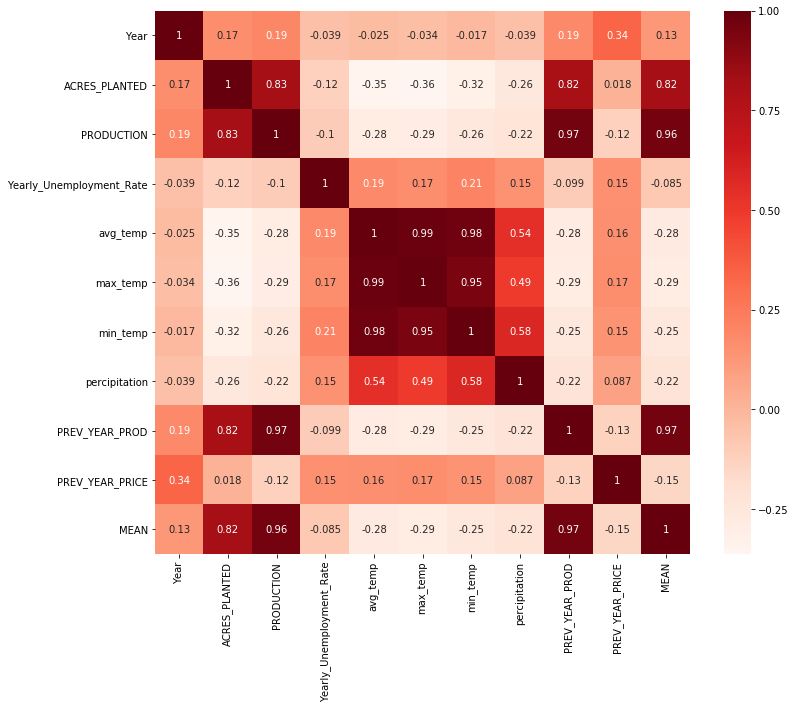

In [4]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = crop_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [5]:
#Focusing on hihly related features.
cor_matrix = cor.drop(columns='PRODUCTION')
cor_matrix = cor_matrix.drop(index='PRODUCTION')
cor_matrix[cor_matrix>0.5]

,Year,ACRES_PLANTED,Yearly_Unemployment_Rate,avg_temp,max_temp,min_temp,percipitation,PREV_YEAR_PROD,PREV_YEAR_PRICE,MEAN
Year,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACRES_PLANTED,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.818529,NaN,0.820287
Yearly_Unemployment_Rate,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_temp,NaN,NaN,NaN,1.000000,0.989251,0.978170,0.544021,NaN,NaN,NaN
max_temp,NaN,NaN,NaN,0.989251,1.000000,0.946298,NaN,NaN,NaN,NaN
min_temp,NaN,NaN,NaN,0.978170,0.946298,1.000000,0.584799,NaN,NaN,NaN
percipitation,NaN,NaN,NaN,0.544021,NaN,0.584799,1.000000,NaN,NaN,NaN
PREV_YEAR_PROD,NaN,0.818529,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.967085
PREV_YEAR_PRICE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
MEAN,NaN,0.820287,NaN,NaN,NaN,NaN,NaN,0.967085,NaN,1.000000


In [6]:
#Selecting features
features_set = list(crop_df.columns)

# dropping highly corrected features

# Weather columns: most of them are highly correlated, but amoungs them Max tempeture has better correlation with target variable.
# And percipitation is also less related to max temperatue. Keeping these two dropping others.
features_set.remove('min_temp')
features_set.remove('avg_temp')

# Production related columns: all of them (ACRES_PLANTED, PREV_YEAR_PROD, MEAN) are highly correlated to production and among each other.
# With such a high correction PREV_YEAR_PROD and MEAN, are direct hint to current year production.
# Limiting to ACRES_PLANTED will keep model relatively balanced. removing remaining.
features_set.remove('PREV_YEAR_PROD')
features_set.remove('MEAN')

#Finally dropping target variable.
filtered_df = crop_df[features_set]
del crop_df
filtered_df.head()

,CROP,Year,ACRES_PLANTED,PRODUCTION,Yearly_Unemployment_Rate,max_temp,percipitation,State-County,PREV_YEAR_PRICE
0,BARLEY,1985,900,4200000,6.333333,53.2,1.95,ARIZONA COCHISE,0.062500
1,BARLEY,1986,500,2016000,6.925000,65.0,0.15,ARIZONA COCHISE,0.058750
2,BARLEY,1987,500,2304000,6.450000,58.4,0.54,ARIZONA COCHISE,0.051458
3,BARLEY,1989,500,2116800,5.358333,56.8,1.32,ARIZONA COCHISE,0.045625
4,BARLEY,1991,1400,6864000,5.966667,56.3,1.55,ARIZONA COCHISE,0.064583


### Prediction with OneHot Encoder

This encoder cannot be used since increases the dimensionality of the data significantly.

In [7]:
from sklearn.preprocessing import OneHotEncoder
# encoding categorical values of CROP and State-County
oneH_encoded_df = filtered_df.copy()
oneH_encoded_df=pd.get_dummies(oneH_encoded_df,prefix=None)
print(oneH_encoded_df.columns)
del oneH_encoded_df

Index(['Year', 'ACRES_PLANTED', 'PRODUCTION', 'Yearly_Unemployment_Rate',
       'max_temp', 'percipitation', 'PREV_YEAR_PRICE', 'CROP_BARLEY',
       'CROP_CORN', 'CROP_PEANUTS',
       ...
       'State-County_WYOMING NATRONA', 'State-County_WYOMING NIOBRARA',
       'State-County_WYOMING PARK', 'State-County_WYOMING PLATTE',
       'State-County_WYOMING SHERIDAN', 'State-County_WYOMING SWEETWATER',
       'State-County_WYOMING TETON', 'State-County_WYOMING UINTA',
       'State-County_WYOMING WASHAKIE', 'State-County_WYOMING WESTON'],
      dtype='object', length=2738)


### Hashing categorical values

Using hashing seems to be a good option, since it keeps the hashed columns independent of any other variables in the data with small number of extra columns. But some information about the original columns might have lost.<br>
We create three groups of features, all features, features with no hints about the production value (so excluding Acers planted, Previous year production and mean historical production) and then features with limited providing hint ( adding back Acers planted).

In [8]:
from category_encoders.hashing import HashingEncoder
h_encoded_df = filtered_df.copy()
hasher = HashingEncoder(return_df=True)
h_encoded_df = hasher.fit_transform(filtered_df)
# h_encoded_df.drop(columns=['CROP','State-County'], inplace=True)
print(h_encoded_df.head())

#Creating feature list
hash_features = list(h_encoded_df.columns)
hash_features.remove('PRODUCTION')

#Features that has no hint of previous year production
hintless_hashFeatures = hash_features.copy()
hintless_hashFeatures.remove('ACRES_PLANTED')

hash_features_set = [hash_features, hintless_hashFeatures]

   col_0  col_1  col_2  col_3  col_4  col_5  col_6  col_7  Year  \
0      0      0      0      1      0      0      1      0  1985   
1      0      0      0      1      0      0      1      0  1986   
2      0      0      0      1      0      0      1      0  1987   
3      0      0      0      1      0      0      1      0  1989   
4      0      0      0      1      0      0      1      0  1991   

   ACRES_PLANTED  PRODUCTION  Yearly_Unemployment_Rate  max_temp  \
0            900     4200000                  6.333333      53.2   
1            500     2016000                  6.925000      65.0   
2            500     2304000                  6.450000      58.4   
3            500     2116800                  5.358333      56.8   
4           1400     6864000                  5.966667      56.3   

   percipitation  PREV_YEAR_PRICE  
0           1.95         0.062500  
1           0.15         0.058750  
2           0.54         0.051458  
3           1.32         0.045625  
4       

In [9]:
from sklearn.model_selection import GridSearchCV

def test_model(features,data, model_type):
    print('Features:\n',features)
    if model_type=='random_forest':
        #testing number of features each tree gets, and number of trees.
        parameters = {'max_features':['sqrt','auto','log2'],'n_estimators':[200,400,600]}
        #Setting random state for consistance results.
        model = RandomForestRegressor(random_state=10, n_jobs=-1)
    elif model_type=='linear':
        #testing effect of normalization
        parameters = {'normalize':['True','False']}
        model = LinearRegression(n_jobs=-1,fit_intercept=False)

    # # Spliting train and test data sets.
    X=data[features]
    y=data['PRODUCTION']
    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

    clf = GridSearchCV(model, parameters, cv=3)
    clf.fit(X_train[features],y_train)
    
    print('\tBest parameters: ',clf.best_params_)
    print('\tBest scores: ',clf.best_score_)
    if model_type=='random_forest':
        print('\tFeature importance:',np.around(clf.best_estimator_.feature_importances_,4)*100)
    elif model_type=='linear':
        print('\tCoefficients: ',clf.best_estimator_.coef_)
    print('\tTest Score:',clf.score(X_test[features],y_test))
    y_predict = clf.predict(X_test)
    y_df = pd.DataFrame({'Actual':y_test,'Predicted':y_predict,'Differece':y_test-y_predict})
    sns.scatterplot('Actual', 'Differece', data=y_df,markers=True,color='r')
    plt.show()
    del y_df
    print('='*50)
#     return clf, clf.predict(X_test), y_train

With GridSearchCV with a random forest model, the results are clear, having no hint at all the prediction suffers. While using all the features the model predicts with a high score. Removing previous year's production and historical means, the model adjusts and put heavy emphasis on Acres Planted. 

Features:
 ['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'Year', 'ACRES_PLANTED', 'Yearly_Unemployment_Rate', 'max_temp', 'percipitation', 'PREV_YEAR_PRICE']
	Best parameters:  {'max_features': 'auto', 'n_estimators': 400}
	Best scores:  0.9669524561174663
	Feature importance: [6.000e-02 7.000e-02 6.000e-02 5.000e-02 8.500e-01 4.000e-02 1.400e-01
 5.000e-02 6.450e+00 7.057e+01 6.700e-01 1.280e+00 7.400e-01 1.897e+01]
	Test Score: 0.9726513183443973


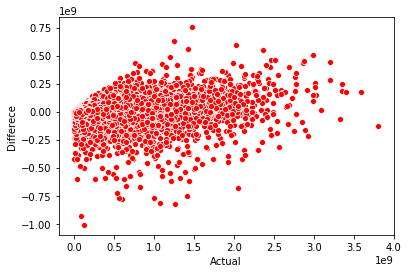

Features:
 ['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'Year', 'Yearly_Unemployment_Rate', 'max_temp', 'percipitation', 'PREV_YEAR_PRICE']
	Best parameters:  {'max_features': 'auto', 'n_estimators': 600}
	Best scores:  0.650293392355613
	Feature importance: [ 0.82  1.03  1.23  1.23  5.4   0.94  1.11  1.05 11.38 15.58 26.19 16.1
 17.95]
	Test Score: 0.6766855997396576


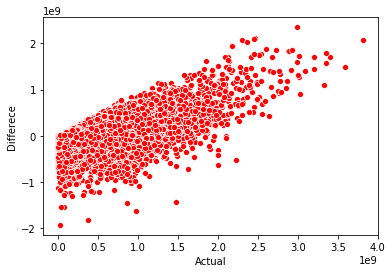

In [10]:
for i, feature in enumerate(hash_features_set):
    test_model(feature, h_encoded_df,'random_forest')

## Linear Regression

Using linear regression instead produces a less favorable model compared to a random forest. But overall the importance of the features remained the same, with a small change in hashed out columns.

Features:
 ['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'Year', 'ACRES_PLANTED', 'Yearly_Unemployment_Rate', 'max_temp', 'percipitation', 'PREV_YEAR_PRICE']
	Best parameters:  {'normalize': 'True'}
	Best scores:  0.7175512110091707
	Coefficients:  [-4.70826842e+09 -4.69485069e+09 -4.65142215e+09 -4.69984762e+09
 -4.73186982e+09 -4.70099101e+09 -4.72973259e+09 -4.70278537e+09
  4.72202688e+06  5.64271646e+03  5.61039800e+06  1.01093197e+06
 -2.04589288e+06 -1.26825350e+09]
	Test Score: 0.7267934158823075


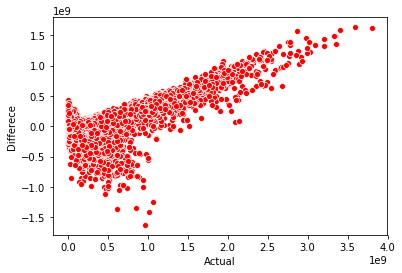

Features:
 ['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'Year', 'Yearly_Unemployment_Rate', 'max_temp', 'percipitation', 'PREV_YEAR_PRICE']
	Best parameters:  {'normalize': 'True'}
	Best scores:  0.17539660876905666
	Coefficients:  [-7.61808190e+09 -7.61633991e+09 -7.56810911e+09 -7.59679636e+09
 -7.57490905e+09 -7.63757374e+09 -7.70981615e+09 -7.59227789e+09
  7.88592841e+06 -3.24221913e+06 -5.85467573e+06 -1.58992032e+07
 -1.03454896e+09]
	Test Score: 0.18158692117659214


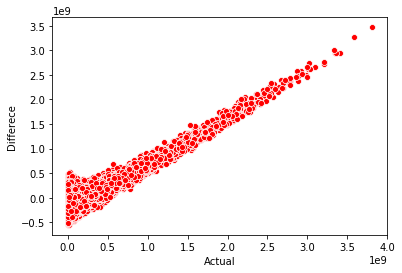

In [11]:
for features in hash_features_set:
   test_model(features,h_encoded_df,'linear')

In [12]:
from statsmodels.formula.api import ols
m = ols('PRODUCTION ~ Year+PREV_YEAR_PRICE+Yearly_Unemployment_Rate+max_temp+percipitation',h_encoded_df).fit()
print(m.summary())
del m

                            OLS Regression Results                            
Dep. Variable:             PRODUCTION   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     4721.
Date:                Fri, 03 May 2019   Prob (F-statistic):               0.00
Time:                        22:33:18   Log-Likelihood:            -2.8856e+06
No. Observations:              137533   AIC:                         5.771e+06
Df Residuals:                  137527   BIC:                         5.771e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               